In [ ]:
import os 
import numpy as np
#Backend can be changed by uncommenting desired setting
os.environ['KERAS_BACKEND'] = 'jax'
#os.environ['KERAS_BACKEND'] = 'tensorflow'
#os.environ['KERAS_BACKEND'] = 'torch'
import keras
import tensorflow as tf
from tensorflow import data as tf_data
import keras.layers as K
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import tarfile
from tqdm import tqdm
%matplotlib inline
sns.set_palette("bright")
sns.set_style("whitegrid")
keras.utils.set_random_seed(0)

In [2]:

#Downloading MedNIST dataset
root_dir = "./"
dataset_url = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/MedNIST.tar.gz"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

downloaded_path = keras.utils.get_file(origin=dataset_url, file_hash=md5, hash_algorithm='md5', extract=True, cache_dir=root_dir)
path_to_downloaded_data = downloaded_path[:-7]
print(path_to_downloaded_data)

#Loading MedNIST dataset
train_dataset, validation_dataset = keras.utils.image_dataset_from_directory(path_to_downloaded_data, validation_split=0.2, subset='both', \
                                       label_mode ='categorical', labels='inferred', color_mode='grayscale', seed=0,)

#map integer label indices to real labels
label_map = {int(idx):name for idx, name in enumerate(train_dataset.class_names)}

./datasets/MedNIST
Found 58954 files belonging to 6 classes.
Using 47164 files for training.
Using 11790 files for validation.


2024-02-18 19:50:34.129635: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


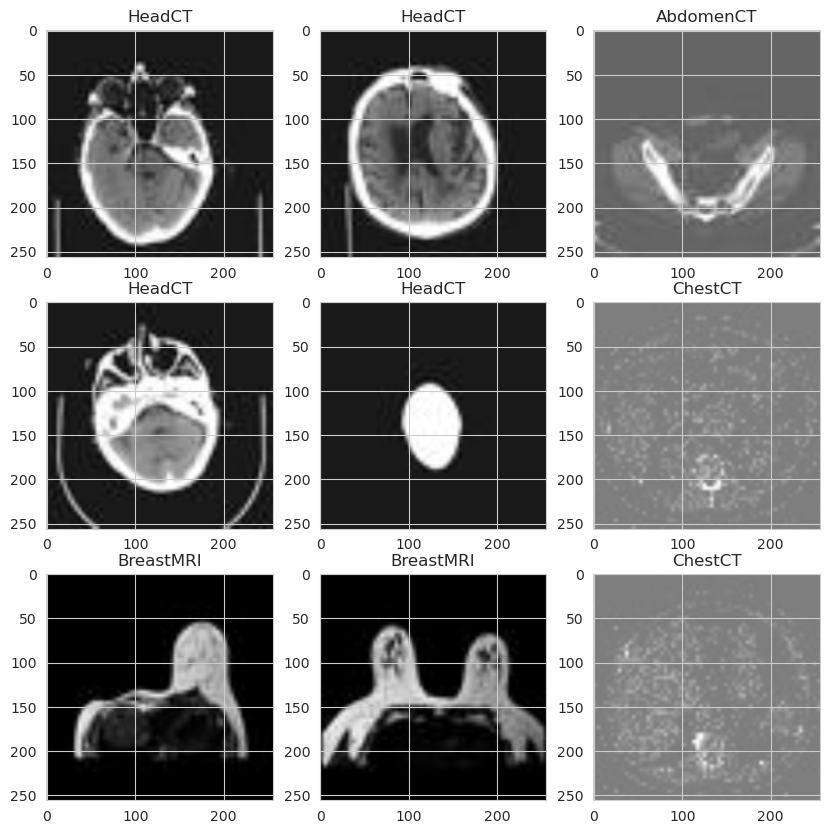

In [3]:
#Plotting images from the dataset
plt.subplots(3, 3, figsize=(10, 10))
for images, labels in train_dataset.take(1):

    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.title(label_map[np.argmax(labels[i])])
        plt.imshow(np.array(images[i]), cmap='gray', vmin=0, vmax=255)
plt.show()


In [4]:

#Applying augmentations to the training images
data_augmentation_layers = [
    K.RandomFlip("horizontal"),
    K.RandomRotation(factor=(-0.1,0.1)),
    K.RandomContrast(0.2)
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images


train_dataset = train_dataset.map(lambda img,label : (data_augmentation(img), label),
                              num_parallel_calls=tf_data.AUTOTUNE,)

train_dataset = train_dataset.prefetch(tf_data.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(tf_data.AUTOTUNE)

model = keras.applications.DenseNet121(include_top=True, weights=None, input_shape=(256,256,1), classes=6, classifier_activation=None)
#print(model.summary())

epochs = 10

callbacks = [
    
    keras.callbacks.ModelCheckpoint("mednist_best_checkpoint.keras", save_best_only=True),
    keras.callbacks.CSVLogger("mednist_classification_training.log"),
]
model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=5e-05),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.CategoricalAccuracy(name="acc")],
)
model.fit(
    train_dataset,
    batch_size=64,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=validation_dataset,
)



Epoch 1/10
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 195s 109ms/step - acc: 0.9689 - loss: 0.1215 - val_acc: 0.9316 - val_loss: 0.1818
Epoch 2/10
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 120s 81ms/step - acc: 0.9975 - loss: 0.0114 - val_acc: 0.9989 - val_loss: 0.0043
Epoch 3/10
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 120s 82ms/step - acc: 0.9975 - loss: 0.0084 - val_acc: 0.9988 - val_loss: 0.0039
Epoch 4/10
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 120s 82ms/step - acc: 0.9976 - loss: 0.0065 - val_acc: 0.9986 - val_loss: 0.0032
Epoch 5/10
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 120s 81ms/step - acc: 0.9994 - loss: 0.0025 - val_acc: 0.9991 - val_loss: 0.0069
Epoch 6/10
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 119s 81ms/step - acc: 0.9985 - loss: 0.0052 - val_acc: 0.9953 - val_loss: 0.0120
Epoch 7/10
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 119s 81ms/step - acc: 0.9994 - loss: 0.0021 - val_acc: 0.9040 - val_loss: 0.2870
Epoch 8/10
1474/1474 ━━━━━━━━━━━━━━━━━━━━ 119s 81ms/step - acc: 0.9995 - loss: 0.0024 - val_acc: 0.9997 - val_loss: 7.6533e-04
Epoch 9/10


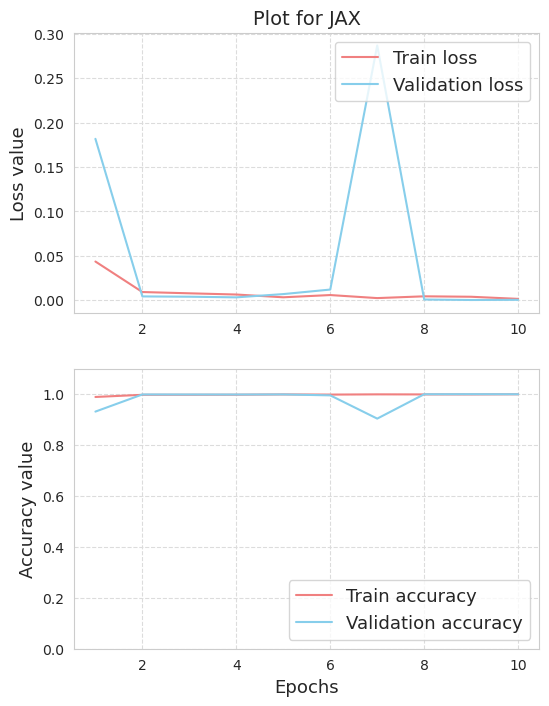

In [5]:
#With all three augmentation
#Plot for jax
history = model.history

train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig, axs = plt.subplots(2,1, figsize=(6,8))

axs[0].plot(list(range(1, epochs+1)), train_loss, color='lightcoral', label='Train loss')
axs[0].plot(list(range(1, epochs+1)), val_loss, color='skyblue', label='Validation loss')
axs[0].set_title("Plot for JAX", fontsize=14)
axs[0].set_ylabel('Loss value',fontsize=13)
axs[0].legend(loc='upper right',fontsize=13)
axs[0].grid(color="gainsboro",linestyle='--')

axs[1].plot(list(range(1, epochs+1)), train_acc, color='lightcoral', label='Train accuracy')
axs[1].plot(list(range(1, epochs+1)), val_acc, color='skyblue', label='Validation accuracy')
axs[1].set_ylabel('Accuracy value',fontsize=13)
axs[1].set_xlabel('Epochs',fontsize=13)
axs[1].set_ylim([0.0,1.1])
axs[1].legend(loc='lower right',fontsize=13)
axs[1].grid(color="gainsboro",linestyle='--')

plt.show()


## Average time 
Average time JAX: 81ms/step 

Average time Torch*: 140ms/step 

Average time Tensorflow: 90ms/step

\* Average time for torch backend may improve if torch dataloader is used instead of tensorflow dataloader.

